In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [3]:
import preprocessing as preproc

In [4]:
def cfs_to_af(cfs_day):
    """
    Convert 'CFS‑days' to acre‑feet:

    acre‑ft = cfs_day / 1.9835
    """
    return cfs_day / 1.9835 


def af_to_m3(acft):
    """Convert acre‑feet to cubic metres (1 af = 1233.48 m³)."""
    return acft * 1233.48

def ft_to_m(ft):
    return ft / 3.281


def kcfs_to_m3hr(kcfs):
    """(1000 cfs = 1kcfs = 28.32 m³/s --> m3/hr """
    return kcfs * 28.32 * 3600


## Data Load

In [6]:
bon_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/bonneville/"
tda_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/dalles/"

In [7]:
## Load Bonneville Data
# Manually fixing timezone (from PST)

bon = pd.read_csv(bon_path + "bon-fullflow.csv")
# bon = pd.read_excel(bon_path + "bon-inflow-calc.xlsx")
bon['Date Time'] = pd.to_datetime(bon['Date Time'])
bon['Date Time'] = bon['Date Time'] + pd.Timedelta(hours=4)

In [8]:
bon.head()

,Date Time,BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-Spill.Ave.1Hour.1Hour.CBT-REV [kcfs]
0,2018-01-01 00:00:00,170.3,NaN,173.8,0.0
1,2018-01-01 01:00:00,171.6,NaN,175.1,0.0
2,2018-01-01 02:00:00,172.2,NaN,175.7,0.0
3,2018-01-01 03:00:00,171.5,NaN,175.0,0.0
4,2018-01-01 04:00:00,172.3,NaN,175.8,0.0


In [9]:
## Load Dalles Data
# Manually fixing timezone (from PST)

tda = pd.read_csv(tda_path + "tda-fullflow.csv")
tda['Date Time'] = pd.to_datetime(tda['Date Time'])
tda['Date Time'] = tda['Date Time'] + pd.Timedelta(hours=4)

In [10]:
tda.head()

,Date Time,TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-Spill.Ave.1Hour.1Hour.CBT-REV [kcfs]
0,2018-01-01 00:00:00,162.6,NaN,163.7,0.0
1,2018-01-01 01:00:00,161.9,NaN,162.9,0.0
2,2018-01-01 02:00:00,163.6,NaN,164.7,0.0
3,2018-01-01 03:00:00,161.9,NaN,162.9,0.0
4,2018-01-01 04:00:00,148.4,NaN,149.4,0.0


## Merge Datasets

In [12]:
inflow_col = "BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]"
# inflow_col = "Calculated Hourly Inflow [kcfs]" 
outflow_col = "TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]"

In [13]:
# Gather Bonneville 6-Hr inflow and convert to m3/hr
flow = bon[["Date Time", inflow_col]].dropna().rename(columns={inflow_col: "inflow_kcfs"})
flow['inflow_m3hr'] = flow['inflow_kcfs'].apply(lambda x: kcfs_to_m3hr(x))

# Merge in with Dalles total outflow data 
flow = flow.merge(tda[["Date Time", outflow_col]], how='inner', on='Date Time').rename(columns={outflow_col: "outflow_kcfs"})
flow['outflow_m3hr'] = flow['outflow_kcfs'].apply(lambda x: kcfs_to_m3hr(x))

# Drop kcfs columns
flow = flow.drop(['inflow_kcfs', 'outflow_kcfs'], axis=1)

In [14]:
len(flow), 365*24*7.5

(11076, 65700.0)

### Outlier Identification

In [16]:
def replace_outliers(data, max_val=1e8):
    """Replace values outside [-max_val, max_val] with average of nearest valid neighbors"""
    arr = np.array(data, dtype=float)
    outlier_count = 0
    
    for i in range(len(arr)):
        if arr[i] > max_val or arr[i] < -max_val:
            outlier_count += 1
            # Find left neighbor
            left = None
            for j in range(i-1, -1, -1):
                if -max_val <= arr[j] <= max_val:
                    left = arr[j]
                    break
            
            # Find right neighbor  
            right = None
            for j in range(i+1, len(arr)):
                if -max_val <= arr[j] <= max_val:
                    right = arr[j]
                    break
            
            # Replace with average of neighbors
            if left is not None and right is not None:
                arr[i] = (left + right) / 2
            elif left is not None:
                arr[i] = left
            elif right is not None:
                arr[i] = right
            else:
                arr[i] = 0
    
    print(f"Found and replaced {outlier_count} outliers")
    return arr

In [17]:
# flow['inflow_m3hr'] = replace_outliers(flow['inflow_m3hr'])

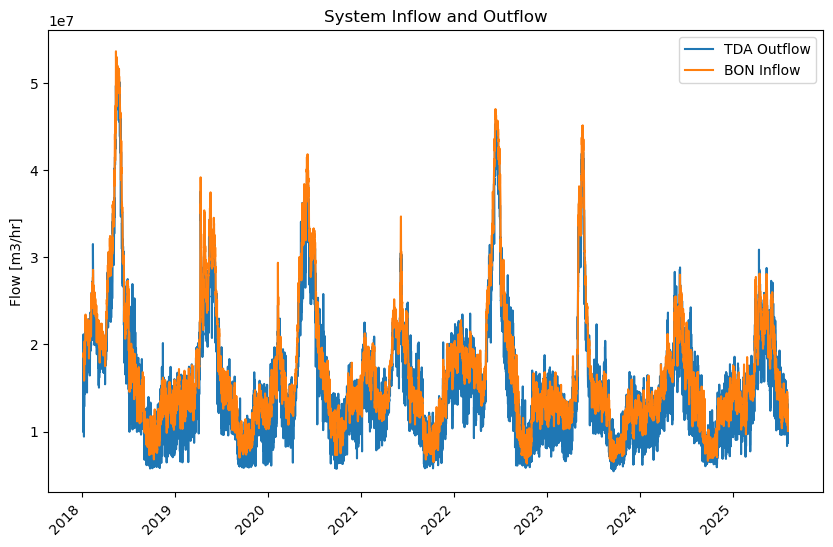

In [82]:
# Visualize Flow Datasets

plt.figure(figsize=(10, 6))
plt.plot(flow['Date Time'], flow['outflow_m3hr'], label = "TDA Outflow")
plt.plot(flow['Date Time'], flow['inflow_m3hr'], label = "BON Inflow")
plt.title('System Inflow and Outflow')
plt.ylabel('Flow [m3/hr]')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

In [19]:
flow.head()

,Date Time,inflow_m3hr,outflow_m3hr
0,2018-01-05 02:00:00,1.881769e+07,18371750.4
1,2018-01-05 08:00:00,1.868770e+07,9940320.0
2,2018-01-05 14:00:00,1.891240e+07,21165235.2
3,2018-01-05 20:00:00,1.906584e+07,19656345.6
4,2018-01-06 02:00:00,1.879455e+07,19381075.2


## Preprocessing

In [21]:
# Step 1: Encode Day of Year

flow['DoY'] = flow['Date Time'].dt.dayofyear
flow['day_sin'] = np.sin(2 * np.pi * flow['DoY'] / 365)
flow['day_cos'] = np.cos(2 * np.pi * flow['DoY'] / 365)

In [22]:
# Step 2: Normalize Data

scaler = StandardScaler() # removes mean and converts to unit variance for each column
flow_norm = scaler.fit_transform(flow.copy().drop(['Date Time'], axis=1))
flow_norm = pd.DataFrame(flow_norm, columns=flow.columns[1:6])

In [122]:
# Access the calculated statistics
print("Mean:", scaler.mean_)           # Mean of each feature
print("Standard deviation:", scaler.scale_)  # Std dev of each feature  
print("Variance:", scaler.var_)        # Variance of each feature

Mean: [ 1.68996587e+07  1.54898894e+07  1.77581437e+02  3.84166261e-02
 -1.24911791e-02]
Standard deviation: [7.56545682e+06 7.33526069e+06 1.04537030e+02 7.02952371e-01
 7.10088796e-01]
Variance: [5.72361369e+13 5.38060494e+13 1.09279906e+04 4.94142035e-01
 5.04226098e-01]


In [134]:
print(f"{'Feature':<20} {'Mean':>12} {'Std Dev':>12} {'Variance':>12}")
print("-" * 58)
for i, col in enumerate(flow.columns[1:3]):
    print(f"{col:<20} {scaler.mean_[i]:>12.2e} {scaler.scale_[i]:>12.2e} {scaler.var_[i]:>12.2e}")

Feature                      Mean      Std Dev     Variance
----------------------------------------------------------
inflow_m3hr              1.69e+07     7.57e+06     5.72e+13
outflow_m3hr             1.55e+07     7.34e+06     5.38e+13


In [23]:
# Step 3: Create lag features

p = 4 + 1
up_feat = True
down_feat = True 
x_col_name = 'outflow_m3hr'
y_col_name = 'inflow_m3hr'

flow_lag, feature_cols = preproc.create_lag_features_colname(flow_norm.copy(), p, x_col_name, y_col_name, up_feat, down_feat)

# Add back in Date Time as index
flow_lag.index = flow["Date Time"]

# Drop rows with NaN values resulting from creating lag features
flow_lag.dropna(inplace=True)

In [24]:
flow_lag.head()

,inflow_m3hr,outflow_m3hr,DoY,day_sin,day_cos,outflow_m3hr_Lag_1,outflow_m3hr_Lag_2,outflow_m3hr_Lag_3,outflow_m3hr_Lag_4,inflow_m3hr_Lag_1,inflow_m3hr_Lag_2,inflow_m3hr_Lag_3,inflow_m3hr_Lag_4
Date Time,,,,,,,,,,,,,
2018-01-06 02:00:00,0.250466,0.530477,-1.641346,0.092019,1.418361,0.568004,0.773707,-0.756561,0.392878,0.286325,0.266044,0.236343,0.253525
2018-01-06 08:00:00,0.210698,-0.014360,-1.641346,0.092019,1.418361,0.530477,0.568004,0.773707,-0.756561,0.250466,0.286325,0.266044,0.236343
2018-01-06 14:00:00,0.241504,0.294196,-1.641346,0.092019,1.418361,-0.014360,0.530477,0.568004,0.773707,0.210698,0.250466,0.286325,0.266044
2018-01-06 20:00:00,0.111501,0.265008,-1.641346,0.092019,1.418361,0.294196,-0.014360,0.530477,0.568004,0.241504,0.210698,0.250466,0.286325
2018-01-07 02:00:00,0.052544,0.180225,-1.631780,0.116354,1.415654,0.265008,0.294196,-0.014360,0.530477,0.111501,0.241504,0.210698,0.250466


## Train / Test Split

In [26]:
train_start_year = '2018'
test_start_year = '2025'

In [84]:
# Test case: restrict top preforming predictors
feature_cols = ['inflow_m3hr_Lag_1', 'outflow_m3hr_Lag_1']

In [86]:
# Split the data into training and testing sets

train_data = flow_lag[(flow_lag.index < test_start_year)]
test_data = flow_lag[(flow_lag.index >= test_start_year)]

X_train = train_data[feature_cols]
y_train = train_data[y_col_name]

X_test = test_data[feature_cols]
y_test = test_data[y_col_name]

In [88]:
X_train.tail()

,inflow_m3hr_Lag_1,outflow_m3hr_Lag_1
Date Time,,
2024-12-30 20:00:00,-0.349364,-0.047717
2024-12-31 02:00:00,-0.407540,-0.338204
2024-12-31 08:00:00,-0.260719,0.003709
2024-12-31 14:00:00,-0.271540,-0.824665
2024-12-31 20:00:00,-0.204807,-0.206164


In [90]:
X_test.head()

,inflow_m3hr_Lag_1,outflow_m3hr_Lag_1
Date Time,,
2025-01-01 02:00:00,-0.262943,-0.201995
2025-01-01 08:00:00,0.025565,0.007878
2025-01-01 14:00:00,0.091328,-0.835784
2025-01-01 20:00:00,0.063769,-0.010190
2025-01-02 02:00:00,-0.314219,-0.135280


## Linear Regression

In [93]:
# Step 1: Add constant (intercept)
X_train_const = sm.add_constant(X_train)

# Step 2: Fit OLS model
model = sm.OLS(y_train, X_train_const).fit(cov_type='HC1') # Heteroskedasticity-consistent

# Step 3: View summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            inflow_m3hr   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.884e+05
Date:                Mon, 18 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:40:39   Log-Likelihood:                 8780.4
No. Observations:               10184   AIC:                        -1.755e+04
Df Residuals:                   10181   BIC:                        -1.753e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0005      0

In [95]:
# Extract coefficients and p-values into a tidy DataFrame
coef_df = pd.DataFrame({
    'feature': model.params.index,
    'coefficient': model.params.values
    #'p_value': model.pvalues.values,
    #'t_value': model.tvalues.values
})

# Optional: sort by absolute coefficient size
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

print(coef_df)

              feature  coefficient
1   inflow_m3hr_Lag_1     0.873086
2  outflow_m3hr_Lag_1     0.127105
0               const    -0.000470


In [97]:
residuals1 = model.resid
fitted_vals1 = model.fittedvalues

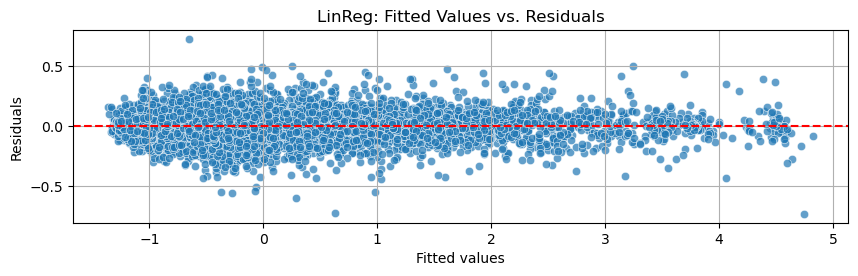

In [99]:
# Checking for Heteroskedasticity

preproc.plot_variance("LinReg", fitted_vals1, residuals1, bounds=False)

In [120]:
from IPython.display import display, Math
import re

def clean_variable_name(feature):
    '''Clean up variable names for LaTeX display'''
    # Replace inflow_m3hr_ with y
    if feature.startswith('inflow_m3hr_'):
        clean_name = feature.replace('inflow_m3hr_', 'y')
    # Replace outflow_m3hr_ with x
    elif feature.startswith('outflow_m3hr_'):
        clean_name = feature.replace('outflow_m3hr_', 'x')
    else:
        clean_name = feature
    
    # Handle Lag_n pattern - convert to subscript t-n
    lag_pattern = r'Lag_(\d+)'
    if re.search(lag_pattern, clean_name):
        # Extract the lag number
        lag_match = re.search(lag_pattern, clean_name)
        lag_num = lag_match.group(1)
        # Replace Lag_n with _{t-n}
        clean_name = re.sub(lag_pattern, f'_{{t-{lag_num}}}', clean_name)
    
    # Escape remaining underscores for LaTeX
    #clean_name = clean_name.replace('_', '\\_')
    
    return clean_name

params = model.params
latex_eq = f"\\hat{{y}} = {params.iloc[0]:.4f}"
for coef, feature in zip(params.iloc[1:], feature_cols):
    sign = "+" if coef >= 0 else "-"
    coef_abs = abs(coef)
    clean_feature = clean_variable_name(feature)
    latex_eq += f" {sign} {coef_abs:.3f} {clean_feature}"

In [103]:
display(Math(latex_eq))

<IPython.core.display.Math object>

### Evaluation

In [106]:
X_test_const = sm.add_constant(X_test)  # Add intercept term
X_test_const['const'] = np.ones(len(X_test))
X_test_const = pd.DataFrame(X_test_const, columns=model.model.exog_names)
y_pred1 = model.predict(X_test_const)

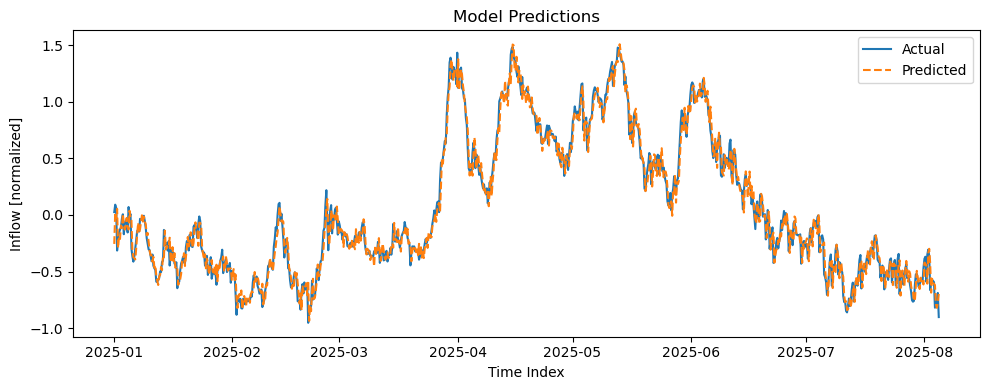

In [108]:
preproc.plot_inflow_forecasts(y_test, y_pred1)

In [109]:
preproc.print_test_stats(y_test, y_pred1)

RMSE: 0.095
MAE: 0.073
R²: 0.976


### Residuals

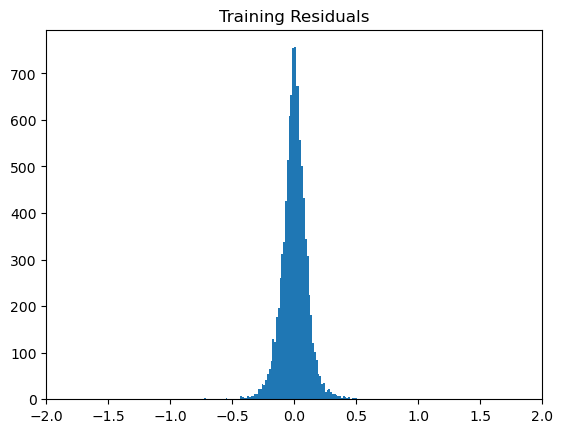

In [113]:
plt.hist(residuals1, bins = 100)
plt.title('Training Residuals')
plt.xlim([-2, 2])
plt.show()

In [115]:
mean = residuals1.mean()
variance = residuals1.var()
(round(mean,3), round(variance, 4))

(0.0, 0.0104)